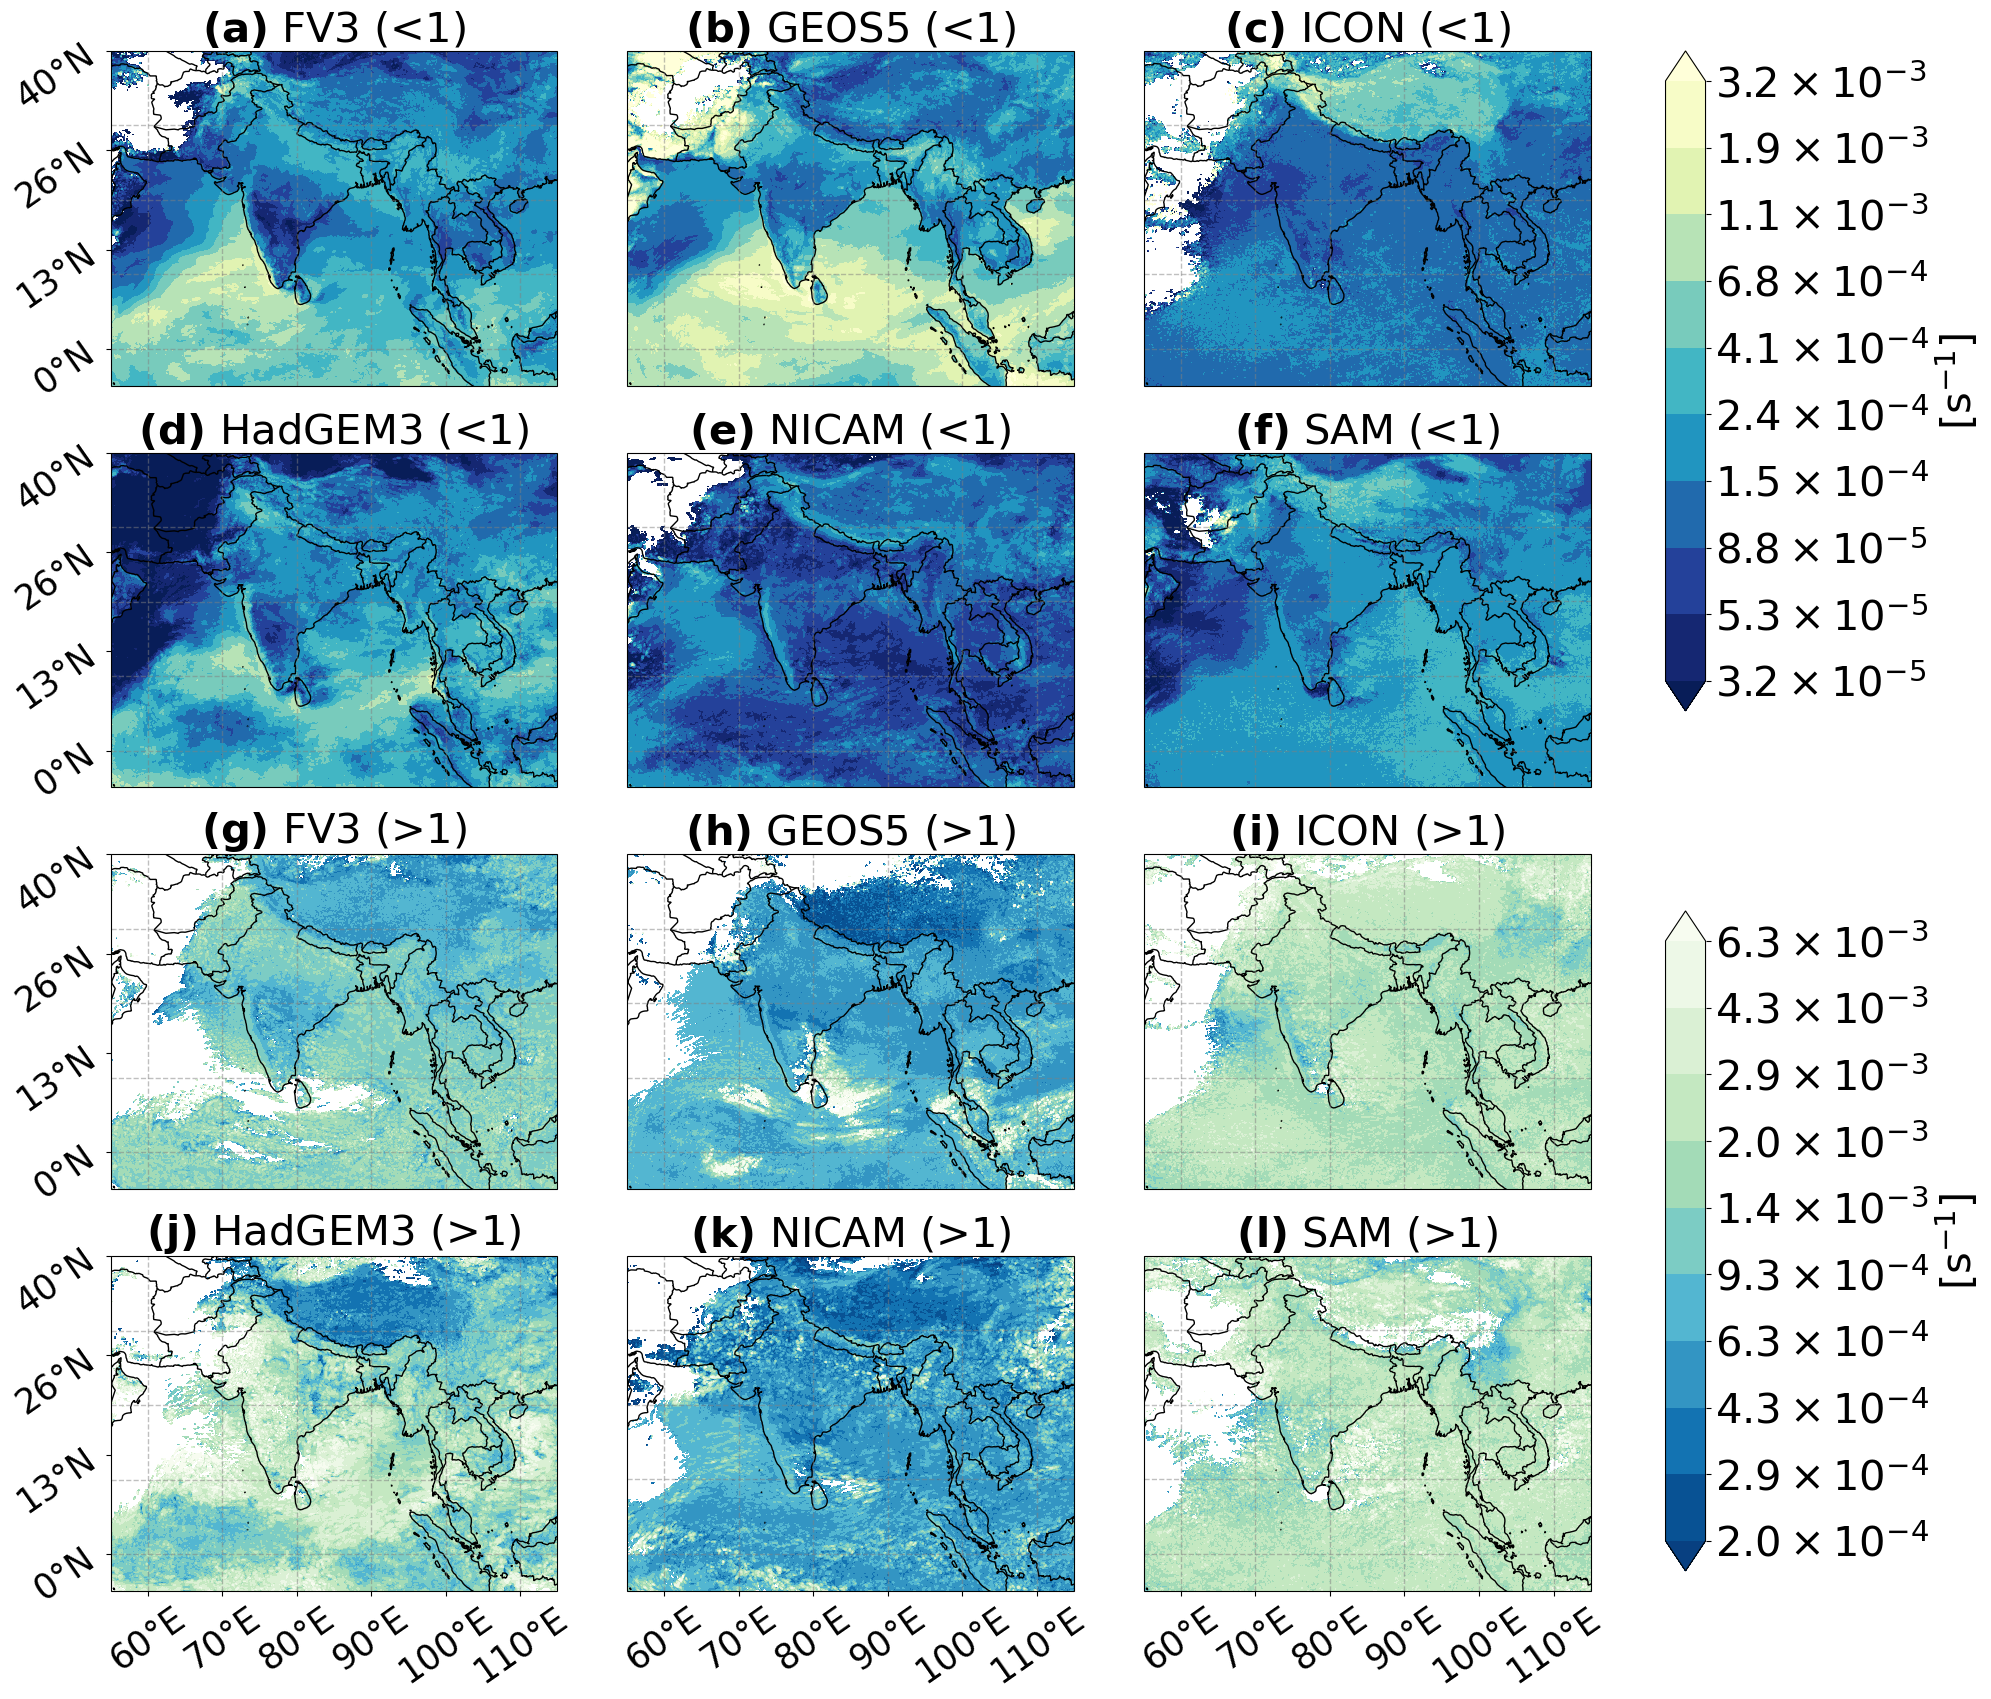

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib import colors
import xarray as xr
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

basedir = '/xdisk/sylvia/temakgoale/DYAMOND/DYAMOND_PRECEFF/TIME_AVERAGING_CWP_FILTERED/'
models = ['FV3', 'GEOS5', 'ICON', 'HadGEM3', 'NICAM', 'SAM']

datasets_0001 = [xr.open_dataset(basedir + f'{model}_PRECEFF_less1mm_hr_20160809-20160909_Asia_timeavg.nc') for model in models]
datasets_1 = [xr.open_dataset(basedir + f'{model}_PRECEFF_1mm_hr_20160809-20160909_Asia_timeavg.nc') for model in models]

vals_0001 = [ds['PRECEFF_TIMEAVG'].values.squeeze() for ds in datasets_0001]
vals_1 = [ds['PRECEFF_TIMEAVG'].values.squeeze() for ds in datasets_1] 
lons_0001 = [ds.lon for ds in datasets_0001]
lats_0001 = [ds.lat for ds in datasets_0001]
lons_1 = [ds.lon for ds in datasets_1]
lats_1 = [ds.lat for ds in datasets_1]

minval, maxval = -4.50, -2.50
minval2, maxval2 = -3.70, -2.20
levs = np.logspace(minval, maxval, 10)
levs2 = np.logspace(minval2, maxval2, 10)

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
gs = GridSpec(4, 3, figure=fig)

def create_contour(ax, lon, lat, vals, levs, cmap, vmin, vmax, title):
    im = ax.contourf(lon, lat, vals, levels=levs, cmap=cmap, extend='both', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    ax.set_title(title, size=30)
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
#    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'size': 25, 'rotation': 35}
    return im 

titles = [rf'$\bf{{({chr(97 + i)})}}$ {model} (<1)' if i < 6 else rf'$\bf{{({chr(97 + i)})}}$ {model} (>1)' for i, model in enumerate(models * 2)]
im = None  
for i in range(6):
    im1 = create_contour(axes[i // 3, i % 3], lons_0001[i], lats_0001[i], vals_0001[i], levs, 'YlGnBu_r', 10**minval, 10**maxval, titles[i])
    im2 = create_contour(axes[(i + 6) // 3, (i + 6) % 3], lons_1[i], lats_1[i], vals_1[i], levs2, 'GnBu_r', 10**minval2, 10**maxval2, titles[i + 6])

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_xticklabels([])

# Enable x-ticks for subplots (i), (j), and (k)
x_tick_indices = [(3, 0), (3, 1), (3, 2)]  # Positions of (i), (j), (k)
xticks = np.linspace(60, 110, 6)  # Example tick positions (adjust as needed)
xtick_labels = [f"{int(t)}°E" for t in xticks]  # Example labels

for row, col in x_tick_indices:
    axes[row, col].set_xticks(xticks)
    axes[row, col].set_xticklabels(xtick_labels, fontsize=25, rotation=35 )
#
# Remove all y-ticks and y-labels first
for ax in axes.flat:
    ax.set_yticks([])
    ax.set_yticklabels([])

# Enable y-ticks for (a), (d), (g), and (j)
y_tick_indices = [(0, 0), (1, 0), (2, 0), (3, 0)]
yticks = np.linspace(0, 40, 4)  # Example tick positions (adjust based on latitude)
ytick_labels = [f"{int(t)}°N" for t in yticks]  # Example labels

for row, col in y_tick_indices:
    axes[row, col].set_yticks(yticks)
    axes[row, col].set_yticklabels(ytick_labels, fontsize=25, rotation=35)
#
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.33])  
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', format=matplotlib.ticker.FuncFormatter(fmt))
cbar1.set_label(r"[s$^{-1}$]", size=30)
cbar1.ax.tick_params(labelsize=30)
plt.setp(cbar1.ax.get_yticklabels(), rotation=0, ha='left', rotation_mode='anchor')

cbar_ax2 = fig.add_axes([0.92, 0.12, 0.02, 0.33])  
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', format=matplotlib.ticker.FuncFormatter(fmt))
cbar2.set_label(r"[s$^{-1}$]", size=30)
cbar2.ax.tick_params(labelsize=30)
plt.setp(cbar2.ax.get_yticklabels(), rotation=0, ha='left', rotation_mode='anchor')
fig.subplots_adjust(wspace=0)
#plt.savefig('/home/u32/temakgoale/Figure_4_SRMs_PRECEFF_CWP_filtered.png', dpi=50, bbox_inches='tight')
#plt.savefig("/home/u32/temakgoale/Figure_4_SRMs_PRECEFF_CWP_filtered.pdf", format="pdf",dpi=50, bbox_inches="tight")